# Libraries

In [1]:
#import GPflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import tensorflow as tf
%matplotlib inline

import time
import copy
import json
import pandas as pd
import scipy as sp
import scipy.stats

# R magic
import rpy2


# the following lines will allow us to convert between Pandas DataFrames and R DataFrames
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py

# this loads the R magic extension
%load_ext rpy2.ipython

### Import CSV

In [2]:
data_prior = np.genfromtxt(fname = "data/for_composititional_analysis_prior.csv", 
                     delimiter = ',',
                     usecols = (1,2,3,4,5),
                     skip_header = 1,
                     dtype=None)

In [3]:
data_posterior =  np.genfromtxt(fname = "data/for_composititional_analysis_posterior.csv", 
                                 delimiter = ',',
                                 usecols = (1,2,3,4,5,6),
                                 skip_header = 1,
                                 dtype=None)

In [4]:
# Transformation of array to matrix
def array_to_matrix(x):
    X = []
    for i in range(len(x)):
        X.append([float(x[i])])
    X = np.array(X)
    return X

# Gaussian Processes
Docs:
- [GP Regression](http://gpflow.readthedocs.io/en/latest/notebooks/regression.html)

In [5]:
def compute(X, Y, kernel_name):
    # Get kernel
    kernel = get_new_kernel(kernel_name)
    
    model = GPflow.gpr.GPR(X, Y, kern = kernel)
    
    try:
        model.optimize()
    except:
        # Add white kernel
        w = GPflow.kernels.White(1, variance = 0.05)
        w.variance.fixed = True
        model = GPflow.gpr.GPR(X, Y, kern = kernel + w)
        
        try:
            print('Adding White Kernel to', kernel_name)
            model.optimize()
        except:
            print('Exception caught computing', kernel_name)
        
    return model

In [6]:
def lml(model):
    """Log marginal likelihood of a GP"""
    
    try:
        return model.compute_log_likelihood()
    except:
        print('Exception caught in lml')
        return -999999999

In [7]:
def predict(gps, X):
    predictions = {}
    
    # For every GP, build predictions
    for key in gps.keys():
        
        try:
            mean, var = gps[key].predict_y(X)
        except:
            print('Exception caught in predict')
            mean, var = np.array([0]), np.array([0])
        
        predictions[key] = {'mean': mean.tolist(), 
                            'var': var.tolist()}
        
    return predictions

In [8]:
def get_new_kernel(kernel_string):
    # Initial new non-optimized kernels
    l = GPflow.kernels.Linear(1)
    p = GPflow.kernels.PeriodicKernel(1)
    r = GPflow.kernels.RBF(1)
    
    if   kernel_string == 'l': return l
    elif kernel_string == 'p': return p
    elif kernel_string == 'r': return r

    elif kernel_string == 'l+r': return  l+r
    elif kernel_string == 'l+p': return  l+p
    elif kernel_string == 'p+r': return  p+r

    elif kernel_string == 'l*r': return  l*r
    elif kernel_string == 'l*p': return  l*p
    elif kernel_string == 'p*r': return  p*r

    elif kernel_string == 'l+r+p': return l+r+p
    elif kernel_string == 'l+r*p': return l+r*p
    elif kernel_string == 'l*r+p': return l*r+p
    elif kernel_string == 'l*p+r': return l*p+r
    elif kernel_string == 'l*r*p': return l*r*p
    
    else: return 'error'

In [9]:
def normalize(Y):
    std = np.std(Y)
    mu = np.mean(Y)
    
    return ((Y - mu)/std)
    

In [10]:
def compute_gps(X, Y0):
    #Y = normalize(Y0)
    Y = Y0
    
    gps = {}

    gps['l'] = compute(X, Y, 'l')
    gps['p'] = compute(X, Y, 'p')
    gps['r'] = compute(X, Y, 'r')

    gps['l+r'] = compute(X, Y, 'l+r')
    gps['l+p'] = compute(X, Y, 'l+p')
    gps['p+r'] = compute(X, Y, 'p+r')

    gps['l*r'] = compute(X, Y, 'l*r')
    gps['l*p'] = compute(X, Y, 'l*p')
    gps['p*r'] = compute(X, Y, 'p*r')

    gps['l+r+p'] = compute(X, Y, 'l+r+p')
    gps['l+r*p'] = compute(X, Y, 'l+r*p')
    gps['l*r+p'] = compute(X, Y, 'l*r+p')
    gps['l*p+r'] = compute(X, Y, 'l*p+r')
    gps['l*r*p'] = compute(X, Y, 'l*r*p')
    
    return gps

In [11]:
def compute_lmls(models):
    lmls = {}
    for key in models.keys():
        lmls[key] = lml(models[key])
        
    return lmls

In [12]:
def gps_to_string(gps):
    strings = {}
    for key in gps.keys():
        strings[key] = str(gps[key])
        
    return strings

In [13]:
def dict_max(d):
    maxval = max(d.values())
    keys = [k for k,v in d.items() if v==maxval]
    return keys, maxval

In [14]:
def save_results(results, filename):
    with open('output/' + filename + '.json', 'w') as fp:
        json.dump(results, fp)

In [15]:
Xpredictions = np.linspace(31, 365*4, int(365*4-31+1))[:,None]

Compute Gaussian Process Models for a dataset

In [16]:
def compute_gps_for_dataset(dataset, Xpredictions=Xpredictions):
    t0 = time.time()
    
    ids = np.unique(dataset['f0'])
    
    gpss_objects = {}
    gpss = {}
    predictions = {}
    lmls = {}
    maxs = {}
    
    for i in ids:
        print(i)
        # Filter the relevant data
        filtered_data = dataset[dataset['f0'] == i]
        
        # Get X and Y
        X = array_to_matrix(filtered_data['f3'])
        Y = array_to_matrix(filtered_data['f4'])
        
        # Compute GPs
        gps = compute_gps(X, Y)
        print('Compute OK')
        
        # Calculate the predictions of the GP given the initial data
        
        # Find the best fitting GP
        likelihoods = compute_lmls(gps)
        best = dict_max(likelihoods)
        print('LMLs OK')
        
        # Make predictions
        gps_predictions = predict(gps, Xpredictions)
        print('Predictions OK')
        
        # Save
        i = str(i)
        #gpss_objects[i] = gps
        gpss[i] = gps_to_string(gps) # The GP parameters
        predictions[i] = gps_predictions
        lmls[i] = likelihoods
        maxs[i] = best
        

    print('Minutes:', str(round((time.time() - t0) / 60)))
        
    return {
            'gpss_objects': gpss_objects, #Actual objects
            'gpss': gpss, 
            'Xpredictions': Xpredictions.tolist(), 
            'predictions': predictions, 
            'lmls': lmls, 
            'maxs': maxs
           }

In [17]:
def plot(X, Y, mean, var):
    xx = Xpredictions
    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(31, 365*4)
    #plt.ylim(-2, 2)

In [18]:
def plot_predictions(results, data, target_id, target_kernel):

    dat = data[data['f0'] == target_id]

    X = array_to_matrix(dat['f3'])
    Y = normalize(array_to_matrix(dat['f4']))

    mean = np.array(results['predictions'][str(target_id)][target_kernel]['mean'])
    var = np.array(results['predictions'][str(target_id)][target_kernel]['var'])

    plot(X, Y, mean, var)

# Compute Gaussian Processes

In [19]:
def debug_filtering(dataset):
    #dataset = dataset[dataset['f0'] == 59]
    #dataset = dataset[dataset['f0'] > 10]
    
    return dataset

In [20]:
def scenario(dataset, scenario):
    return dataset[dataset['f2'] == scenario]

In [21]:
np.unique(data_prior['f2'])

array([b'"FB Friends"', b'"Gym members"', b'"Rain"', b'"Salary"',
       b'"Sales"', b'"Temperature"'], 
      dtype='|S13')

### Prior condition

In [22]:
#dataset = debug_filtering(data_prior)
#results_prior = compute_gps_for_dataset(dataset)
#save_results(results_prior, 'results_prior')

### Posterior condition (only evidence)

In [23]:
#dataset = debug_filtering(data_posterior)

# Only the evidence
#dataset = dataset[dataset['f3'] < (365-31+1)]

#results_posterior = compute_gps_for_dataset(dataset)
#save_results(results_posterior, 'results_posterior')

# Plots

In [ ]:
plot_predictions(results_posterior, data_posterior, 8, 'l+p')

In [ ]:
plot_predictions(results_prior, data_prior, 9, 'l+r*p')

# Results analysis

R libraries

In [24]:
%%R
source("tools.R")

/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr

  warnings.warn(x, RRuntimeWarning)


### Import the results

In [25]:
with open('output/results_prior.json', 'r') as fp:
    results_prior = json.load(fp)

In [26]:
with open('output/results_posterior.json', 'r') as fp:
    results_posterior = json.load(fp)

### Functions to analyze data

In [69]:
%%R
kernels <- c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p")

get_proportions <- function(res_x) {
    total <- length(res_x[1][[1]])

    props <- res_x %>% 
                group_by(kernel) %>%
                summarize(proportion = length(kernel)/total)
    
    props$kernel <- factor(props$kernel, levels=kernels)
    
    # Adding zeros
    for (k in kernels){
        # If the kernel is NOT present
        if (sum(props$kernel == k) == 0){
            new_row <- c(k, 0)
            
            props <- rbind(props, new_row)
        } 
    }
    
    # Reorder factors
    #props$kernel <- factor(props$kernel, levels=c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p"))
    
    props$proportion <- as.numeric(props$proportion)
    
    return (props)
}

In [70]:
%%R

plot_proportions <- function(prop_data, title, hide_x=FALSE, hide_y=FALSE) {
    plot <- prop_data %>%
                ggplot(aes(x=kernel, y=proportion)) + 
                    geom_bar(stat="identity") +
                    ylim(0, 0.5) +
                    labs(title = title) +
                    #ggthemes::theme_few() +
                    xlab("Kernel composition") + ylab("Proportion") +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"),
                          plot.title = element_text(hjust = 0.5))
    
    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

### Proportions of best fitting kernel composition in the Prior condition, per scenario

In [71]:
maxs_prior = pd.DataFrame(data=results_prior['maxs']).T
maxs_prior.columns = ['kernel', 'lml']

for i in maxs_prior.index:
    maxs_prior['kernel'][i] = maxs_prior['kernel'][i][0]
    
maxs_prior['id'] = maxs_prior.index.values.tolist()

maxs_prior_i = maxs_prior['id'].values.tolist()
maxs_prior_k = maxs_prior['kernel'].values.tolist()
maxs_prior_l = maxs_prior['lml'].values.tolist()

#maxs_posterior =  = pd.Series(results_posterior['maxs'])

Data prior

In [72]:
%%R 
data_prior <- read_csv("data/for_composititional_analysis_prior.csv")

dict_prior <- data_prior %>% 
                        group_by(id, scenario) %>%
                        summarize()

/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double()
)

  warnings.warn(x, RRuntimeWarning)


In [73]:
%%R -i maxs_prior_i,maxs_prior_k,maxs_prior_l

maxs_prior <- data.frame(id=maxs_prior_i,kernel=maxs_prior_k,lml=maxs_prior_l)

maxs_prior <- merge(x = maxs_prior, y = dict_prior, by = c("id", "id"), all.x = TRUE)

In [74]:
%R maxs_prior$scenario %>% unique


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:34: unexpected symbol
1: withVisible({maxs_prior<function scenario
                                     ^


/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:1:34: unexpected symbol
1: withVisible({maxs_prior<function scenario
                                     ^

  warnings.warn(x, RRuntimeWarning)
/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/qv/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Missing column names filled in: 'X1' [1] 

  warnings.warn(x, RRuntimeWarning)


In [75]:
%%R
maxs_prior_temperature <- maxs_prior %>% filter(scenario == "Temperature")
maxs_prior_rain <- maxs_prior %>% filter(scenario == "Rain")
maxs_prior_sales <- maxs_prior %>% filter(scenario == "Sales")
maxs_prior_gym <- maxs_prior %>% filter(scenario == "Gym members")
maxs_prior_salary <- maxs_prior %>% filter(scenario == "Salary")
maxs_prior_fb <- maxs_prior %>% filter(scenario == "FB Friends")

prop_temperature <- get_proportions(maxs_prior_temperature)
prop_rain <- get_proportions(maxs_prior_rain)
prop_sales <- get_proportions(maxs_prior_sales)
prop_gym <- get_proportions(maxs_prior_gym)
prop_salary <- get_proportions(maxs_prior_salary)
prop_fb <- get_proportions(maxs_prior_fb)

In [80]:
%%R
p1 <- plot_proportions(prop_temperature, "Temperature", hide_x=TRUE)
p2 <- plot_proportions(prop_rain, "Rain")
p3 <- plot_proportions(prop_sales, "Sales", hide_x=TRUE, hide_y=TRUE)
p4 <- plot_proportions(prop_gym, "Gym members", hide_y=TRUE)
p5 <- plot_proportions(prop_salary, "Salary", hide_x=TRUE, hide_y=TRUE)
p6 <- plot_proportions(prop_fb, "FB Friends", hide_y=TRUE)

#svg("Images/kernels_prior.svg", width=8, height=4)
#multiplot(p1, p2, p3, p4, p5, p6, cols=3)
#dev.off()

png 
  2 


### Compare the best kernel composition SSE versus those of `l` and `r`

Functions

In [27]:
def get_posterior_curve(cid):
    cid = int(cid)
    dataset = data_posterior
    
    # Filter the relevant data
    filtered_data = dataset[dataset['f0'] == cid]
    
    # Get X and Y
    x = filtered_data['f3']
    y = filtered_data['f4']
    
    df = pd.DataFrame([x, y]).T
    
    df.columns=["x", "y"]
    
    return df

In [28]:
def get_posterior_prediction(cid, kernel_name):
    # Get the target values
    x = Xpredictions
    
    y = results_posterior['predictions'][cid][kernel_name]['mean']
    
    y_var = results_posterior['predictions'][cid][kernel_name]['var']
    
    # Squeeze the matrices
    x = np.squeeze(x); y = np.squeeze(y); y_var = np.squeeze(y_var); 
    
    df = pd.DataFrame([x, y, y_var]).T
    
    df.columns=["x", "y", "y_var"]
    
    return df

In [29]:
def get_y_value(df, x):
    return df[df['x']==x]['y'].tolist()[0]

In [30]:
def compute_SSE(true_dataframe, prediction_dataframe, minX = 365-31):
    
    df1 = true_dataframe[true_dataframe['x'] > minX]
    df2 = prediction_dataframe[prediction_dataframe['x'] > minX]
    
    sse = 0
    
    for x in df1['x'] :
        error = get_y_value(df1, x) - get_y_value(df2, x)
        sse += (error*error)
        
    # Root mean squared deviation
    rmsd = np.sqrt(sse / len(df1))
    
    # Normalized
    return rmsd / (np.max(df1['y']) - np.min(df1['y']))

In [31]:
columns = ["cid", "sse_l", "sse_r", "sse_best"]

sses = pd.DataFrame(columns = columns)

for cid in np.unique(data_prior['f0']):
    
    if cid != 533:
        cid = str(cid)
        
        # Get the best kernel for the curve
        best_kernel_name = results_prior['maxs'][cid][0][0]

        # Gest the predictions of the l, r, and best kernel
        prediction_l = get_posterior_prediction(cid, 'l')
        prediction_r = get_posterior_prediction(cid, 'r')
        prediction_best = get_posterior_prediction(cid, best_kernel_name)

        # Get the actual values in the posterior condition
        prediction = get_posterior_curve(cid)

        # Calculate the Sum of squared errors
        sse_l = compute_SSE(prediction, prediction_l)
        sse_r = compute_SSE(prediction, prediction_r)
        sse_best = compute_SSE(prediction, prediction_best)

        results = pd.DataFrame([cid, sse_l, sse_r, sse_best]).T
        results.columns = ["cid", "sse_l", "sse_r", "sse_best"]

        sses = sses.append(results, ignore_index=True)

In [32]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

Summarizing

In [33]:
print('NRMSD    Mean  -CI95  +CI95')

print ('Linear:', np.round(mean_confidence_interval(sses['sse_l']),2))

print ('RBF:   ', np.round(mean_confidence_interval(sses['sse_r']),2))

print ('Best:  ', np.round(mean_confidence_interval(sses['sse_best']),2))

NRMSD    Mean  -CI95  +CI95
Linear: [ 8.12  7.58  8.67]
RBF:    [ 2.24  2.09  2.39]
Best:   [ 2.25  2.04  2.46]


In [64]:
sse_l = sses['sse_l'].tolist()
sse_r = sses['sse_r'].tolist()
sse_best = sses['sse_best'].tolist()

In [65]:
%%R -i sse_l,sse_r,sse_best

sse_l = data.frame(kernel="l", sse=sse_l)
sse_r = data.frame(kernel="r", sse=sse_r)
sse_best = data.frame(kernel="best", sse=sse_best)

sses = rbind(sse_l, sse_r, sse_best)

In [92]:
%%R
p <- ggplot(sses, aes(x=kernel, y=sse, group=kernel)) +
        geom_point(alpha=0.1, aes(size=3)) +
        xlab("Kernel composition") + ylab("NMSE") +
        theme(text = element_text(size=20, family="serif"),
            plot.title = element_text(hjust = 0.5),
            legend.position="none")

svg("Images/kernels_nmse2.svg")
p
dev.off()

png 
  2 


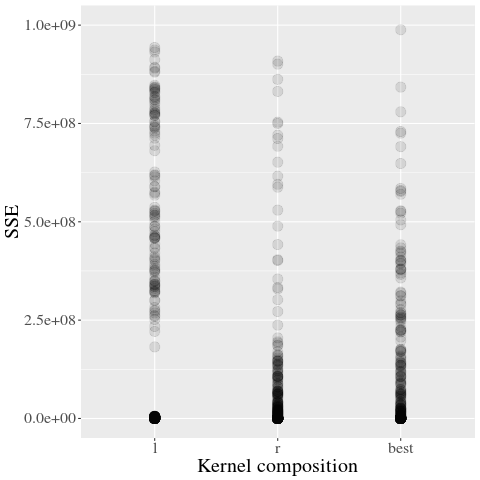

In [278]:
%%R
p <- ggplot(sses, aes(x=kernel, y=sse, group=kernel)) +
        geom_point(alpha=0.1, aes(size=3)) +
        xlab("Kernel composition") + ylab("NMSE") +
        theme(text = element_text(size=20, family="serif"),
            plot.title = element_text(hjust = 0.5),
            legend.position="none")

Calculate the SSE for every prediction

In [ ]:
1+1

# DEBUG

In [ ]:
results_prior['maxs']

In [ ]:
data['maxs']